# Setup

In [1]:
pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [6]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-15 15:36:42.727766: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 15:36:43.235251: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-06-15 15:36:43.235304: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30968 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [41]:
config = json.load(open("./configs/siam_char_mlstm_falzone_amazon_lr_0.01.json"))

# Loading data

In [8]:
from data_loader.abo import ABO

In [9]:
data = ABO(path=config["data"]["path"],
           download=True,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'description2', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,description2,product_type,label
0,mobile coverb07t6mm8xxamazon brand - solimo de...,mobile coverb07t6mm8xxamazon brand - solimo de...,CELLULAR_PHONE_CASE,1
1,mobile cover zenfone liteb07th2yqhmamazon bran...,mobile coverb07tg44tqzamazon brand - solimo de...,CELLULAR_PHONE_CASE,0
2,mobile coverb07tf1bzhzamazon brand - solimo de...,back coverb07tbv4g33amazon brand - solimo desi...,CELLULAR_PHONE_CASE,0
3,mobile coverb07z41hryqamazon brand - solimo de...,mobile coverb07z41hryqamazon brand - solimo de...,CELLULAR_PHONE_CASE,1
4,cellphonecoverb0853x8gjwamazonbasics 2 oz comp...,cellphonecoverb0853x9mv1amazon brand - solimo ...,CELLULAR_PHONE_CASE,0
...,...,...,...,...
168180,mobile coverb07t254pn2amazon brand - solimo de...,mobile coverb07t264yvlamazon brand - solimo de...,CELLULAR_PHONE_CASE,0
168181,samsung galaxy m31 mobile caseb08511fgv8amazon...,back coverb07t2lkp46amazon brand - solimo rech...,CELLULAR_PHONE_CASE,0
168182,mobile coverb0821d5ph6amazon brand - solimo de...,mobile coverb0821d5ph6amazon brand - solimo de...,CELLULAR_PHONE_CASE,1
168183,back coverb0854gk7nyamazon brand - solimo desi...,back coverb0854gk7nyamazon brand - solimo desi...,CELLULAR_PHONE_CASE,1


In [10]:
text = data["description"]
text2 = data["description2"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [11]:
tk = CharTokenizer(config["data"]["alphabet"], config["data"]["input_size"])
text = tk.tokenize(text)
text.shape

(168185, 70)

In [12]:
text2 = tk.tokenize(text2)
text2.shape

(168185, 70)

# Save embeddings

In [13]:
model_name = config["model"]["name"]

In [14]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/{model_name}")

In [15]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/text.npy", text)
np.save(f"{save_path}/text2.npy", text2)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [16]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,description2,product_type,label
0,mobile coverb07t6mm8xxamazon brand - solimo de...,mobile coverb07t6mm8xxamazon brand - solimo de...,CELLULAR_PHONE_CASE,1
1,mobile cover zenfone liteb07th2yqhmamazon bran...,mobile coverb07tg44tqzamazon brand - solimo de...,CELLULAR_PHONE_CASE,0
2,mobile coverb07tf1bzhzamazon brand - solimo de...,back coverb07tbv4g33amazon brand - solimo desi...,CELLULAR_PHONE_CASE,0
3,mobile coverb07z41hryqamazon brand - solimo de...,mobile coverb07z41hryqamazon brand - solimo de...,CELLULAR_PHONE_CASE,1
4,cellphonecoverb0853x8gjwamazonbasics 2 oz comp...,cellphonecoverb0853x9mv1amazon brand - solimo ...,CELLULAR_PHONE_CASE,0
...,...,...,...,...
168180,mobile coverb07t254pn2amazon brand - solimo de...,mobile coverb07t264yvlamazon brand - solimo de...,CELLULAR_PHONE_CASE,0
168181,samsung galaxy m31 mobile caseb08511fgv8amazon...,back coverb07t2lkp46amazon brand - solimo rech...,CELLULAR_PHONE_CASE,0
168182,mobile coverb0821d5ph6amazon brand - solimo de...,mobile coverb0821d5ph6amazon brand - solimo de...,CELLULAR_PHONE_CASE,1
168183,back coverb0854gk7nyamazon brand - solimo desi...,back coverb0854gk7nyamazon brand - solimo desi...,CELLULAR_PHONE_CASE,1


In [17]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(168185, 70)

In [18]:
text2 = np.load(f"{save_path}/text2.npy", allow_pickle=True)
text2.shape

(168185, 70)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [19]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [20]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train, test, labels_train, labels_test = train_test_split(
    data,
    labels,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [23]:
text_train = text[train.index]
text_test = text[test.index]

text2_train = text2[train.index]
text2_test = text2[test.index]

# Build Siamese Char-CNN MLSTM

![](../../assets/images/MNN_EM.png)

In [24]:
from utils.metrics import create_metrics

In [25]:
# load model
with open("../../models/siam_char_mlstm_falzone.json", 'r') as json_file:
    architecture = json.load(json_file)
    model = tf.keras.models.model_from_json(json.dumps(architecture))

/home/es/es_es/es_kamait02/.local/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: nn_bidirectional is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,
/home/es/es_es/es_kamait02/.local/lib/python3.9/site-packages/keras/layers/core/lambda_layer.py:307: UserWarning: nn_bidirectional is not loaded, but a Lambda layer uses it. It may cause errors.
  output_shape = cls._parse_function_from_config(config, custom_objects,


In [26]:
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_left (InputLayer)        [(None, 70)]         0           []                               
                                                                                                  
 input_right (InputLayer)       [(None, 70)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 70, 69)       4830        ['input_left[0][0]',             
                                                                  'input_right[0][0]']            
                                                                                                  
 conv1d (Conv1D)                (None, 66, 32)       11072       ['embedding[0][0]',          

In [27]:
tf.keras.utils.plot_model(model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [28]:
from utils.metrics import create_callbacks, create_metrics

In [29]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
img_model = config["img_model"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [30]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"])

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [33]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [ ]:
metrics = create_metrics(config["model"]["training"]["metrics"])

In [34]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Training

In [35]:
history = model.fit(
    x=[text_train, text2_train],
    y=labels_train,
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    callbacks=callbacks)

Epoch 1/10


2023-06-15 15:37:12.124796: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700


8513/8514 [============================>.] - ETA: 0s - loss: 0.2749 - recall: 0.8948 - precision: 0.8779 - binary_accuracy: 0.8805 - cosine_similarity: 0.5202

2023-06-15 15:38:09.526151: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/Siamaese_Char_MLSTM_Falzone_ABO/cls_1/./Adam/lr_0.01/assets


INFO:tensorflow:Assets written to: ./runs/models/Siamaese_Char_MLSTM_Falzone_ABO/cls_1/./Adam/lr_0.01/assets


8514/8514 [==============================] - 68s 7ms/step - loss: 0.2749 - recall: 0.8948 - precision: 0.8779 - binary_accuracy: 0.8805 - cosine_similarity: 0.5202 - val_loss: 0.0927 - val_recall: 1.0000 - val_precision: 0.9482 - val_binary_accuracy: 0.9718 - val_cosine_similarity: 0.5166
Epoch 2/10
8508/8514 [============================>.] - ETA: 0s - loss: 0.1321 - recall: 0.9519 - precision: 0.9586 - binary_accuracy: 0.9536 - cosine_similarity: 0.5202

INFO:tensorflow:Assets written to: ./runs/models/Siamaese_Char_MLSTM_Falzone_ABO/cls_1/./Adam/lr_0.01/assets


INFO:tensorflow:Assets written to: ./runs/models/Siamaese_Char_MLSTM_Falzone_ABO/cls_1/./Adam/lr_0.01/assets


8514/8514 [==============================] - 61s 7ms/step - loss: 0.1322 - recall: 0.9519 - precision: 0.9586 - binary_accuracy: 0.9536 - cosine_similarity: 0.5202 - val_loss: 0.0587 - val_recall: 1.0000 - val_precision: 0.9688 - val_binary_accuracy: 0.9833 - val_cosine_similarity: 0.5166
Epoch 3/10
8514/8514 [==============================] - 52s 6ms/step - loss: 0.1118 - recall: 0.9630 - precision: 0.9624 - binary_accuracy: 0.9611 - cosine_similarity: 0.5202 - val_loss: 0.0777 - val_recall: 1.0000 - val_precision: 0.9481 - val_binary_accuracy: 0.9717 - val_cosine_similarity: 0.5166
Epoch 4/10
8514/8514 [==============================] - 52s 6ms/step - loss: 0.1199 - recall: 0.9583 - precision: 0.9574 - binary_accuracy: 0.9562 - cosine_similarity: 0.5202 - val_loss: 0.0692 - val_recall: 1.0000 - val_precision: 0.9587 - val_binary_accuracy: 0.9777 - val_cosine_similarity: 0.5166
Epoch 5/10
8514/8514 [==============================] - 52s 6ms/step - loss: 0.1279 - recall: 0.9570 - preci

# Evaluation

## Plot loss and metrics

In [36]:
from utils.metrics import plot_metrics

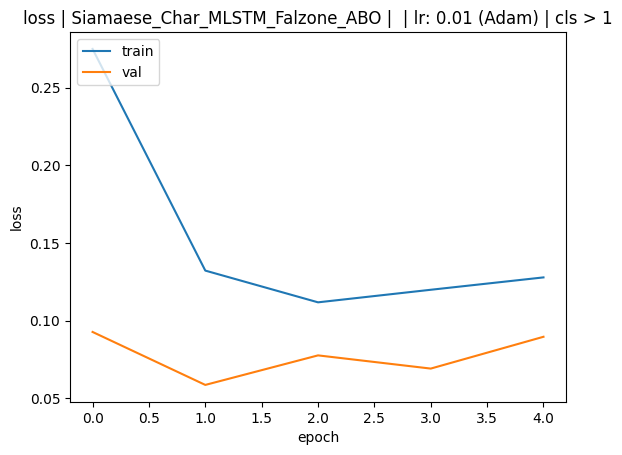

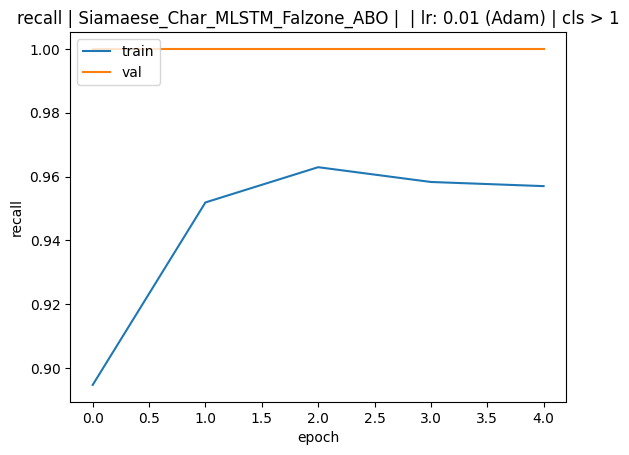

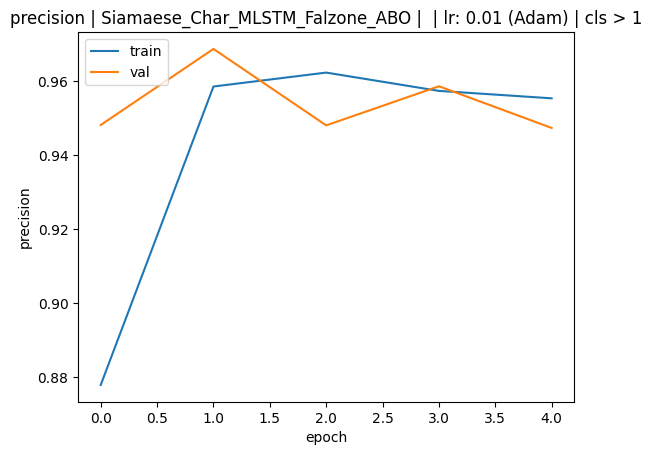

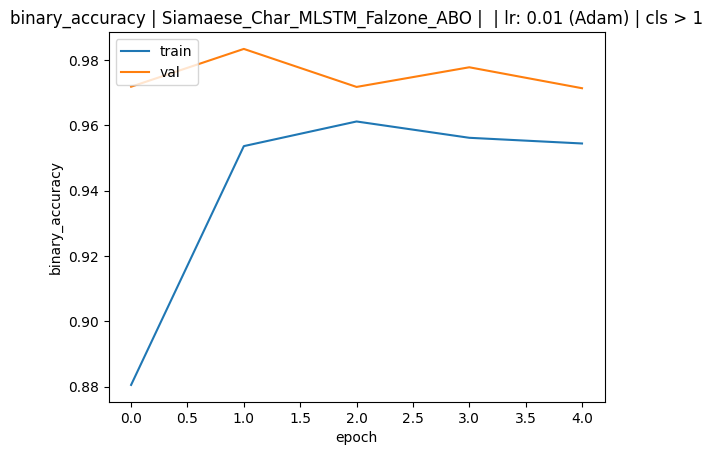

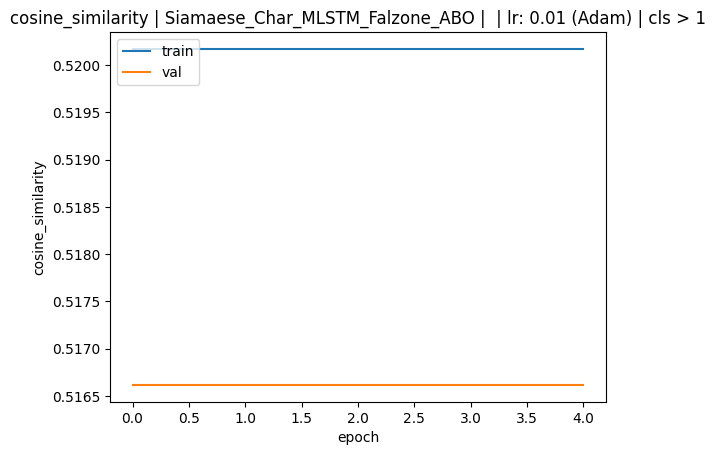

In [37]:
plot_metrics(history.history, config["model"]["training"]["metrics"],
             model_name, img_model, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [38]:
from utils.metrics import evaluate

In [40]:
evaluate(model, [text_test, text2_test], labels_test, log_dir, model_name,
         img_model, optimizer_name, learning_rate, config["data"]["cls"])

16817/16817 [==============================] - 55s 3ms/step - loss: 0.0796 - recall: 1.0000 - precision: 0.9512 - binary_accuracy: 0.9735 - cosine_similarity: 0.5174
